# Analysis of New York Motor Vehicle Collisions
### UCDPA Project, Hauke Laing

## Setup

In [2]:
# import required libraries
import requests
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

## Data Collection

### helper functions

In [3]:
def read_api_chunk(api, limit=1000, offset=0):
    """read a single chunk from the api"""
    return pd.read_json(f"{api}?${limit=}&${offset=}")


def read_api(api, total_size, chunk_size=1000):
    """read given number of lines from api, applying the chunk_size along the way"""
    # use https://docs.python.org/3/reference/expressions.html#yield-expressions
    chunk_generator = (
        # define chunks; the last chunk might be smaller than chunk_size
        read_api_chunk(api, limit=min(chunk_size, total_size - x), offset=x)
        for x in range(0, total_size, chunk_size)
    )
    # in the generator expressions, the chunks are not yet read and stored in memory
    # the outer paranthesis are synctactilly required for generator expressions; they
    # are not included simply in order to permit the multiline definition

    # pd.concat can handle generator expressions. According to the api reference, the objs argument
    # accepts a sequence of DataFrame objects. This indicates that any iterable that yields DataFrame
    # objects will be accepted, which is what chunk_generator provides.
    return pd.concat(chunk_generator)

def read_api_2(api, size, n_chunks):
    """read given number of lines from api by splitting the request into n_chunks chunks"""
    grid = np.unique(np.linspace(0, size, num=n_chunks).astype('int'))
    steps = np.diff(grid)
    chunk_generator = (
        read_api_chunk(api, limit=steps[i], offset=grid[i])
        for i in range(len(steps))
    )
    return pd.concat(chunk_generator)

### inputs

In [4]:
# set input parameters
api = "https://data.cityofnewyork.us/resource/h9gi-nx95.json"
n = 100e3
n_chunks = 4
# limit = 1000

### read data

In [5]:
# read data
# data_raw = read_api_chunk(api, limit=int(n))
# data_raw = read_api(api, total_size=int(100e3), chunk_size=int(25e3))
data_raw = read_api_2(api, size=n, n_chunks=n_chunks)

In [6]:
data_raw.shape

(100000, 29)

## Data Preparation 

### Cleaning

In [7]:
# initial cleaning of data
data_raw_2 = data_raw.rename(
    columns={
        "vehicle_type_code1": "vehicle_type_code_1",
        "vehicle_type_code2": "vehicle_type_code_2",
    }
)
data_raw_2 = data_raw_2.reindex(sorted(data_raw_2.columns), axis=1)
text_cols = [col for col in data_raw_2 if re.search("(street|contributing_factor)", col)]
data_raw_2[text_cols] = data_raw_2[text_cols].astype("string")
data_raw_2.shape

(100000, 29)

In [8]:
# set index
data_raw_2.set_index(keys="collision_id", drop=False, inplace=True)
# ensure index is unique
data_raw_2 = data_raw_2[~data_raw_2.index.duplicated(keep='first')]

In [9]:
# plausibility check
invalid_number_of_injured = (
    data_raw_2[
        [
            "number_of_pedestrians_injured",
            "number_of_cyclist_injured",
            "number_of_motorist_injured",
        ]
    ].sum(axis=1)
    > data_raw_2["number_of_persons_injured"]
)
sum(invalid_number_of_injured)

0

In [10]:
# add column to indicate if a cyclist was injured
data_raw_3 = data_raw_2.assign(cyclist_was_injured=lambda x: x.number_of_cyclist_injured > 0)

### Explore

In [11]:
# explore dataset
occ = data_raw_3["number_of_cyclist_injured"].value_counts()
print(occ)

number_of_cyclist_injured
0    95420
1     4509
2       66
3        5
Name: count, dtype: int64


In [12]:
print(occ / sum(occ))

number_of_cyclist_injured
0    0.95420
1    0.04509
2    0.00066
3    0.00005
Name: count, dtype: float64


The ration of collisions where no cyclist was injured is very high. This ratio can also be seen as the accuracy of an algorithm that predicts that no cyclist ever gets injured in a collision. This will be an important benchmark for machine learning algorithms - they should certainly be better than that if they are of any use. 

### Wrangle

In [13]:
# the dataset has 5 columns to cover up to 5 vehicles involved in a collision
# format data to cover 5 vehicles in one column
data_long = pd.wide_to_long(
    data_raw_3,
    stubnames=["vehicle_type_code_", "contributing_factor_vehicle_"],
    i="collision_id",
    j="vehicle_no",
)
data_long.rename(
    columns={
        "vehicle_type_code_": "vehicle_type_code",
        "contributing_factor_vehicle_": "contributing_factor_vehicle",
    },
    inplace=True,
)
data_long = data_long.reindex(sorted(data_long.columns), axis=1)


# keep rows for vehicle no. > 1 only if relevant information pertaining to the vehicle is present; the row is redundant otherwise
_cnd1 = (
    data_long[["vehicle_type_code", "contributing_factor_vehicle"]]
    .notnull()
    .any(axis=1)
)
_cnd2 = data_long.index.get_level_values(level=1) == 1
_cnd = _cnd1 | _cnd2
data_long = data_long.loc[_cnd, :]
# export long data
# data_long.to_csv("data_long.csv")
data_long.dtypes

borough                                  object
contributing_factor_vehicle      string[python]
crash_date                               object
crash_time                       datetime64[ns]
cross_street_name                string[python]
cyclist_was_injured                        bool
latitude                                float64
location                                 object
longitude                               float64
number_of_cyclist_injured                 int64
number_of_cyclist_killed                  int64
number_of_motorist_injured                int64
number_of_motorist_killed                 int64
number_of_pedestrians_injured             int64
number_of_pedestrians_killed              int64
number_of_persons_injured                 int64
number_of_persons_killed                  int64
off_street_name                  string[python]
on_street_name                   string[python]
vehicle_type_code                        object
zip_code                                

In [14]:
# explore the column 'contributing_factor_vehicle'
data_long["contributing_factor_vehicle"].value_counts()

contributing_factor_vehicle
Unspecified                                          104204
Driver Inattention/Distraction                        28037
Following Too Closely                                  7870
Failure to Yield Right-of-Way                          7588
Passing or Lane Usage Improper                         5269
Unsafe Speed                                           4239
Passing Too Closely                                    4225
Other Vehicular                                        3981
Traffic Control Disregarded                            3418
Backing Unsafely                                       3285
Turning Improperly                                     2485
Unsafe Lane Changing                                   2352
Driver Inexperience                                    2283
Alcohol Involvement                                    1643
Reaction to Uninvolved Vehicle                         1550
Pedestrian/Bicyclist/Other Pedestrian Error/Co...      1225
View Obstruc

In [15]:
# The column 'contributing_factor_vehicle' contains a text comment. To prepare the column 
# for machine learning algorithms, we want to categorize it and later create dummies

# First, establish a code representing a contributing factor and a corresponding mapping

confac = (
    data_long["contributing_factor_vehicle"]
    .drop_duplicates()
    .dropna()
    .reset_index(drop=True)
    .to_frame(name="contributing_factor")
)

def get_first_chars(input):
    """retrieve first character of each word in a string of words"""
    return "".join(item[0].upper() for item in re.findall("\w+", input))

# create initial code
confac["cf"] = confac["contributing_factor"].apply(get_first_chars)

# if code is not unique, add counting index
confac["n"] = confac.groupby(["cf"]).cumcount()
_k = confac["n"] > 0
confac.loc[_k, "cf"] = confac.loc[_k, "cf"] + confac.loc[_k, "n"].astype("string")
confac.set_index("contributing_factor", inplace=True)

# export mapping for reference
confac.to_csv("output/confac.csv")

confac_cols = "cf." + confac["cf"]
mapping_cf = pd.Series(confac["cf"]).to_dict()

In [16]:
# determine dummies grouped by collision_id
data_long["cf"] = data_long["contributing_factor_vehicle"].replace(mapping_cf)
# dummies_cf_long = pd.get_dummies(data_long, columns=["cf"], prefix_sep=".")
# dummies_cf = dummies_cf_long[confac_cols].groupby(level=0).max()
# dummies_cf["n_vehicles"] = dummies_cf.sum(axis=1) # store number of vehicles involved
# dummies_cf.head()
data_long["cf"].value_counts()

cf
U         104204
DID        28037
FTC         7870
FTYROW      7588
POLUI       5269
US          4239
PTC         4225
OV          3981
TCD         3418
BU          3285
TI          2485
ULC         2352
DI          2283
AI          1643
RTUV        1550
PBOPEC      1225
VOL         1052
PS          1034
ADRR         835
OV1          497
FA           453
BD           424
PD           275
SF           270
OD           241
OCD          238
LC           197
TFI          193
I            174
PD1          149
G            146
FTKR         133
FD           133
DRV          109
DI1           94
AA            88
AD            83
TCDINW        65
CPHH          50
PD2           42
LMII          33
TW            31
PM            19
VV            16
OLD           15
UOBND         14
HD            11
THD           11
OED           10
EOD            8
CPHF           8
SDI            6
T              5
LUH            4
WI             2
Name: count, dtype: Int64

In [17]:
# similar to the column 'contributing factor' is the column 'vehicle type'
# we want to prepare it as categorical data

# vehicle_type_codes = data_long["vehicle_type_code"].astype("string").dropna()

# align formatting of text
data_long["vehicle_type"] = (
    data_long["vehicle_type_code"]
    .str.replace(pat=r"\W+", repl="_", regex=True)
    .str.lower()
)

print(data_long["vehicle_type"].nunique())
print(data_long["vehicle_type"].value_counts())

429
vehicle_type
sedan                                  82786
station_wagon_sport_utility_vehicle    60671
bike                                    4950
pick_up_truck                           3873
box_truck                               3841
                                       ...  
citywide                                   1
pro_master                                 1
rgr                                        1
us_postal                                  1
c3                                         1
Name: count, Length: 429, dtype: int64


In [18]:
# reduce to top 50 most frequent types of cars. last category is set to "other"
top = 50
vehicle_top_cats = data_long["vehicle_type"].value_counts().head(top - 1).index
data_long["vt"] = data_long["vehicle_type"]

data_long.loc[
    ~data_long["vehicle_type"].isin(vehicle_top_cats)
    & ~data_long["vehicle_type"].isna(),
    ["vt"],
] = "other"

data_long["vt"] = data_long["vt"].astype("category")
data_long["vt"].value_counts()

vt
sedan                                  82786
station_wagon_sport_utility_vehicle    60671
bike                                    4950
pick_up_truck                           3873
box_truck                               3841
taxi                                    3716
bus                                     3052
e_bike                                  2734
motorcycle                              1715
tractor_truck_diesel                    1431
e_scooter                               1385
van                                     1205
ambulance                               1050
other                                    869
moped                                    686
dump                                     628
pk                                       427
flat_bed                                 363
garbage_or_refuse                        354
convertible                              342
carry_all                                262
motorscooter                             240
tow_tru

In [19]:
# now we are ready to create dummies from the 'contributing factor' and
# 'vehicle type' columns. The processed versions of these columns have been 
# stored as 'cf' and 'vt'

dummies_long = pd.get_dummies(
    data_long, prefix=["vt", "cf"], columns=["vt", "cf"], prefix_sep="."
)
dummies = dummies_long.filter(regex=r"^(vt|cf)\.").groupby(level=0).max()
dummies["n_vehicles"] = dummies.filter(regex=r"^cf\.").sum(axis=1) # store number of vehicles involved
# after using contributing factor to deduce the number of involved vehicles
# we drop the dummie for the value 'Unspecified', as it can now be regarded as NaN
dummies = dummies.drop(columns=["cf." + mapping_cf["Unspecified"]])
dummies.head()

,vt.3_door,vt.4_dr_sedan,vt.ambulance,vt.armored_truck,vt.beverage_truck,vt.bike,vt.box_truck,vt.bus,vt.carry_all,vt.chassis_cab,...,cf.THD,cf.TI,cf.TW,cf.ULC,cf.UOBND,cf.US,cf.VOL,cf.VV,cf.WI,n_vehicles
collision_id,,,,,,,,,,,,,,,,,,,,,
3456194,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3460534,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3528065,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
3618395,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3869923,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1


In [20]:
# after creating dummies, it is useful to create a copy of
# the data with the source columns for the dummies removed
data_raw_4 = data_raw_3.drop(
    columns=[
        "vehicle_type_code_1",
        "vehicle_type_code_2",
        "vehicle_type_code_3",
        "vehicle_type_code_4",
        "vehicle_type_code_5",
        "contributing_factor_vehicle_1",
        "contributing_factor_vehicle_2",
        "contributing_factor_vehicle_3",
        "contributing_factor_vehicle_4",
        "contributing_factor_vehicle_5"
    ]
)



In [21]:
collisions = data_raw_4.join(dummies)
# collisions.to_csv("output/collisions.csv")

## Algorithm Setup

In [22]:
# import performance metrix
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn-metrics-confusion-matrix
from sklearn.metrics import accuracy_score, confusion_matrix

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split
from sklearn.model_selection import train_test_split, cross_val_score, KFold


In [23]:
# split data
X = collisions.filter(regex=r"^(vt|cf)\.", axis=1)
y = collisions["number_of_cyclist_injured"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [24]:
print(occ / sum(occ))

number_of_cyclist_injured
0    0.95420
1    0.04509
2    0.00066
3    0.00005
Name: count, dtype: float64


### Decision Trees

In [44]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier


In [42]:
dt = DecisionTreeClassifier(
    # min_samples_leaf=20,
    max_depth=5,
    random_state=42
)
dt.fit(X_train, y_train)
dt.score(X_test, y_test)

0.98112

In [43]:
confusion_matrix(y_test, dt.predict(X_test))


array([[23537,   264,     0],
       [  188,   991,     0],
       [    7,    13,     0]], dtype=int64)

In [51]:
et = ExtraTreeClassifier(
)
et.fit(X_train, y_train)
et.score(X_test, y_test)

0.98016

In [53]:
confusion_matrix(y_test, et.predict(X_test))

array([[23534,   266,     1],
       [  209,   970,     0],
       [    8,    12,     0]], dtype=int64)

### Ridge Classification

In [83]:
# test ridge classifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier
ridge = RidgeClassifier(
    # class_weight="balanced"
)
ridge.fit(X_train, y_train)
ridge.score(X_test, y_test)


0.98128

In [55]:
confusion_matrix(y_test, ridge.predict(X_test))

array([[23540,   261,     0],
       [  187,   992,     0],
       [    7,    13,     0]], dtype=int64)

In [63]:
ridge_cv = RidgeClassifier()
ridge_cv.fit(X_train, y_train)
ridge_cv.score(X_test, y_test)

0.98128

In [64]:
confusion_matrix(y_test, ridge_cv.predict(X_test))

array([[23540,   261,     0],
       [  187,   992,     0],
       [    7,    13,     0]], dtype=int64)

### BernoulliNB

In [60]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
bnb.score(X_test, y_test)

0.98112

In [58]:
confusion_matrix(y_test, bnb.predict(X_test))

array([[23536,   265,     0],
       [  187,   992,     0],
       [    7,    13,     0]], dtype=int64)

### GaussianNB

In [61]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb.score(X_test, y_test)

0.06896

In [62]:
confusion_matrix(y_test, gnb.predict(X_test))

array([[ 1578,  4621, 14394,  3208],
       [   21,   135,   803,   220],
       [    0,     2,    11,     7],
       [    0,     0,     0,     0]], dtype=int64)

### Random Forest

In [66]:
# test random tree classifier
from sklearn.ensemble import RandomForestClassifier

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn-ensemble-randomforestclassifier
rf = RandomForestClassifier(
    # n_estimators=10
    )
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.9802

In [67]:
confusion_matrix(y_test, rf.predict(X_test))

array([[23524,   276,     1],
       [  198,   981,     0],
       [    7,    13,     0]], dtype=int64)

In [268]:
from sklearn.neighbors import KNeighborsClassifier

# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn-neighbors-kneighborsclassifier
clf_knn = KNeighborsClassifier(algorithm="ball_tree")
clf_knn = clf_knn.fit(X_train, y_train)
clf_knn.score(X_test, y_test)

### Gradient Boosting

In [35]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [40]:
gb = GradientBoostingClassifier(
    # n_estimators=10, 
    # learning_rate=0.0,
    # max_depth=1,
    # random_state=0
)
gb.fit(X_train, y_train)
gb.score(X_test, y_test)

0.98076

In [41]:
confusion_matrix(y_test, gb.predict(X_test))

array([[23538,   260,     0,     3],
       [  185,   981,     0,    13],
       [    7,    12,     0,     1],
       [    0,     0,     0,     0]], dtype=int64)

### Hyperparameter Boosting

In [98]:
from sklearn.model_selection import GridSearchCV
kf = KFold(n_splits=5, random_state=12, shuffle=True)

params = [
    {'alpha':[0.01, 0.1, 0.2, 0.5, 0.7, 1, 2]}
]

ridge_cv = GridSearchCV(RidgeClassifier(), params, cv=kf)

ridge_cv.fit(X_train, y_train)
ridge_cv.cv_results_

{'mean_fit_time': array([0.09684153, 0.09602752, 0.09923382, 0.0963675 , 0.09473748,
        0.09976053, 0.09668889]),
 'std_fit_time': array([0.00382012, 0.00282505, 0.00396796, 0.00226315, 0.00182117,
        0.005048  , 0.00344464]),
 'mean_score_time': array([0.00882449, 0.01079803, 0.00871587, 0.00881553, 0.0088366 ,
        0.00933576, 0.00928187]),
 'std_score_time': array([0.00038929, 0.0022262 , 0.00041435, 0.00036994, 0.00075671,
        0.00097498, 0.00080447]),
 'param_alpha': masked_array(data=[0.01, 0.1, 0.2, 0.5, 0.7, 1, 2],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.01},
  {'alpha': 0.1},
  {'alpha': 0.2},
  {'alpha': 0.5},
  {'alpha': 0.7},
  {'alpha': 1},
  {'alpha': 2}],
 'split0_test_score': array([0.9828    , 0.98286667, 0.98286667, 0.98286667, 0.98286667,
        0.98293333, 0.98293333]),
 'split1_test_score': array([0.9824, 0.9824, 0.9824, 0.9824, 0.9824, 0.9824

In [99]:
ridge_cv.best_params_

{'alpha': 1}

## Visualisation

In [71]:
# https://campus.datacamp.com/courses/supervised-learning-with-scikit-learn/preprocessing-and-pipelines-4?ex=14
# # Create models dictionary
models = {
    "Ridge": RidgeClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    # "Random Forest": RandomForestClassifier()
    'Bernoulli NB': BernoulliNB()
}
results = []

# Loop through the models' values
for model in models.values():
    # Instantiate a KFold object
    kf = KFold(n_splits=10, random_state=12, shuffle=True)

    # Perform cross-validation
    cv_results = cross_val_score(model, X_train, y_train, cv=kf)
    results.append(cv_results)

results

[array([0.98186667, 0.984     , 0.98173333, 0.98306667, 0.98293333,
        0.98053333, 0.98066667, 0.9804    , 0.98373333, 0.98173333]),
 array([0.98106667, 0.9812    , 0.97986667, 0.9816    , 0.98213333,
        0.97826667, 0.97853333, 0.97813333, 0.9824    , 0.98      ]),
 array([0.98146667, 0.9828    , 0.98133333, 0.98266667, 0.98133333,
        0.97933333, 0.97986667, 0.97986667, 0.984     , 0.98053333])]

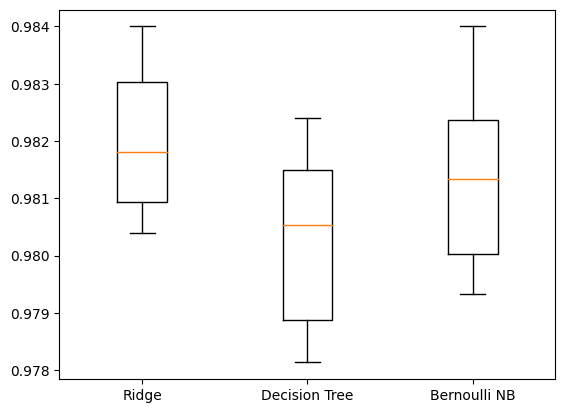

In [72]:
plt.boxplot(results, labels=models.keys())
plt.show()

### Ensemble methods

In [77]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(estimator=RidgeClassifier(), algorithm="SAMME", n_estimators=100)
abc.fit(X_train, y_train)
abc.score(X_test, y_test)

0.97872

In [78]:
from sklearn.ensemble import BaggingClassifier
bc = BaggingClassifier()
bc.fit(X_train, y_train)
bc.score(X_test, y_test)

0.97988

In [80]:
from sklearn.ensemble import VotingClassifier
estimators = [
    ('ridge', RidgeClassifier()),
    ('bernoulli', BernoulliNB()), 
    ('tree', DecisionTreeClassifier())
]

vc = VotingClassifier(estimators=estimators, voting="hard")
vc.fit(X_train, y_train)
vc.score(X_test, y_test)

0.98128

In [81]:
confusion_matrix(y_test, vc.predict(X_test))

array([[23541,   260,     0],
       [  188,   991,     0],
       [    7,    13,     0]], dtype=int64)

In [39]:
from sklearn.pipeline import make_pipeline, Pipeline

pipe = make_pipeline([clf_ridge, clf_rfc, clf_dct])
# pipe.fit(X_train, y_train)

TypeError: Last step of Pipeline should implement fit or be the string 'passthrough'. '[RidgeClassifier(), RandomForestClassifier(n_estimators=10), DecisionTreeClassifier(min_samples_leaf=3, min_samples_split=9,
                       random_state=500)]' (type <class 'list'>) doesn't

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

# # Prepare the list of tuples with the first-layer classifiers


clf_ridge = RidgeClassifier()
clf_rfc = RandomForestClassifier(n_estimators=10)
clf_dct = DecisionTreeClassifier(
    min_samples_leaf=3, min_samples_split=9, random_state=500
)

classifiers = [clf_ridge, clf_rfc, clf_dct]

estimators = [
    # ('ridge', RidgeClassifier()),
    ("random_forest", RandomForestClassifier(n_estimators=10)),
    (
        "decision_tree",
        DecisionTreeClassifier(
            min_samples_leaf=3, min_samples_split=9, random_state=500
        ),
    ),
]

# Instantiate the second-layer meta estimator
clf_meta = LogisticRegression()
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression

# Build the stacking classifier
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn-ensemble-stackingclassifier
clf_stack = StackingClassifier(
    estimators=estimators,
    final_estimator=clf_meta,
    # stack_method='predict_proba',
    passthrough=False,
)


clf_stack.fit(X_train, y_train)
clf_stack.score(X_test, y_test)

c:\Users\hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:1166: RuntimeWarning: Number of classes in training fold (12) does not match total number of classes (13). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
c:\Users\hauke\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:1166: RuntimeWarning: Number of classes in training fold (12) does not match total number of classes (13). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(
c:\Users\hauke\AppData\Local\Progr

0.71872

In [28]:
zip(*classifiers)

TypeError: 'RidgeClassifier' object is not iterable

In [ ]:
clf_rfc.get_params()

## Roads

In [ ]:
# data["on_street_name"].str.split(" ")

## Cyclists

### Injured Cyclists

In [ ]:
data["number_of_cyclist_injured"].value_counts(dropna=True)
# data.head(10)

### Contributing factors